In [1]:
%run 00_analysis_config.ipynb

Welcome to JupyROOT 6.24/06


In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
import visualization as vis
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import include_modules_root as rt
cut=cutflow.sample_space("")


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
# Figure configuration are saved in this file include_figure_preset.py
from include_figure_preset import * 
# Set Figure font family, fontsize, ticks, etc.
plt_config(family="san-serif", fontsize_multi=1) # or "serif", or an exact font name

# Redefine a function to save figures with common settings 
fig_prefix = "plots/singletrack_Pion_"    # It's good to keep figures in a separate folder. Can also be set to None.
fig_format = "jpg"      # for multiple formats, e.g.: "pdf,png"
SAVE_FIG = True         # Use this flag to turn the figure saving on or off, so that you don't need to modify all notebook to save figure.
# You can then do `savefig(filename_without_extension)` to save your plots with these settings
savefig = Save_fig(fig_prefix=fig_prefix, exts=fig_format, SAVE= SAVE_FIG, dpi=300)

# Single track performance, pion

- Parameter resolution vs Momentum
- Efficiency

In [4]:

vin=1.77
vout = vin/(214+75j)*(200j+20)
abs(vout)

1.5688943167411693

In [5]:
#--- Get a list of filenames to process ---
# energy_list = [1, 2, 5, 10, 50, 100, 1000]
# energy_list = [0.5, 1, 3, 10, 50, 1000]
energy_list = [0.5, 1, 3, 10, 100]
file_list = {}
for energy in energy_list:
    files=glob.glob(f"{DATA_DIR}/pion_{energy}_GeV/*/*/stat_seedmod.root",)
    #files=util.Utils.sortByExt(files)
    if len(files)>=1:
        file_list[energy]=files[0]
    if len(files)>1:
        print(f"More than one file for {energy} GeV")
pp.pprint(file_list)

{   0.5: '/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_0.5_GeV/20230411/185206/stat_seedmod.root',
    1: '/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_1_GeV/20230411/185206/stat_seedmod.root',
    3: '/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_3_GeV/20230411/185206/stat_seedmod.root',
    10: '/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_10_GeV/20230412/175710/stat_seedmod.root',
    100: '/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_100_GeV/20230418/181223/stat_seedmod.root'}


In [6]:
results={}
for energy in energy_list:
    print("Processing energy ",energy, "GeV")
    
    tfile = root.TFile.Open(file_list[energy])
    Tree = tfile.Get("integral_tree")
    nevents = int(Tree.GetEntries())    

    truth=[]
    truth_nlayer=[]
    
    recon=[]
    recon_unc=[]
    ndigi_total=[]
    ndigi_track=[]
    ndigi_inds=[]
    ntracks=[]
    mask_recon_success=[]
    
    
    for Entry in tqdm(range(nevents)):
    # for Entry in range(40000):
        Tree.GetEntry(Entry)
        
        # Get truth (speed need to be calculated by hand)
        try:
            # Truth position and speed
            dt=Tree.Hit_time[1]-Tree.Hit_time[0]
            vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
            vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
            vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
            truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0],vz,vx,vy])  
            
            # Truth number of layer the first partical goes through
            pdgids = np.array([Tree.Hit_particlePdgId[i] for i in range(len(Tree.Hit_particlePdgId))])
            ind_lasthit = int(np.argmax(pdgids!=pdgids[0]))-1
            y_lasthit = Tree.Hit_y[ind_lasthit]
            y_layer = cut.in_layer(y_lasthit)
            truth_nlayer.append(y_layer)      
            
        except:
            truth.append([-9999, -9999, -9999, -9999, -9999, -9999, -9999])
            truth_nlayer.append(-9999)
           
            
        
        # If there is reconstruction:
        if len(Tree.Track_k_m_z0)==0:
            recon.append([-9990, -9990, -9990, -9990, -9990, -9990, -9990])
            recon_unc.append([-9990, -9990, -9990, -9990, -9990, -9990, -9990])
            ndigi_total.append(-9999)
            ndigi_track.append(-9999)
            ndigi_inds.append([-9999])
            ntracks.append(-9999)
            mask_recon_success.append(False)
        else:
            # Check which one is closest to truth
            track_digi_hit_inds = util.unzip(Tree.Track_k_m_hitIndices)
            track_digi_hit_len = np.array([len(i) for i in track_digi_hit_inds])
            track_chi2s = []
            
            if len(track_digi_hit_inds)>1:
                for track_ind in range(len(track_digi_hit_inds)):
                    recon_i = [Tree.Track_k_m_z0[track_ind], Tree.Track_k_m_x0[track_ind], Tree.Track_k_m_y0[track_ind], Tree.Track_k_m_t0[track_ind],Tree.Track_k_m_velZ[track_ind], Tree.Track_k_m_velX[track_ind], Tree.Track_k_m_velY[track_ind]]
                    recon_i_unc = [Tree.Track_k_m_ErrorZ0[track_ind], Tree.Track_k_m_ErrorX0[track_ind], Tree.Track_k_m_ErrorY0[track_ind], Tree.Track_k_m_ErrorT0[track_ind],Tree.Track_k_m_ErrorVz[track_ind], Tree.Track_k_m_ErrorVx[track_ind], Tree.Track_k_m_ErrorVy[track_ind]]
                    chi2 = util.chi2_calc(recon_i,truth[-1],recon_i_unc)
                    track_chi2s.append(chi2)
                #     print("s")
                #     print(track_chi2s)
                track_ind = int(np.argmin(track_chi2s))
            else:
                track_ind=0
            recon_i = [Tree.Track_k_m_z0[track_ind], Tree.Track_k_m_x0[track_ind], Tree.Track_k_m_y0[track_ind], Tree.Track_k_m_t0[track_ind],Tree.Track_k_m_velZ[track_ind], Tree.Track_k_m_velX[track_ind], Tree.Track_k_m_velY[track_ind]]
            recon_i_unc = [Tree.Track_k_m_ErrorZ0[track_ind], Tree.Track_k_m_ErrorX0[track_ind], Tree.Track_k_m_ErrorY0[track_ind], Tree.Track_k_m_ErrorT0[track_ind],Tree.Track_k_m_ErrorVz[track_ind], Tree.Track_k_m_ErrorVx[track_ind], Tree.Track_k_m_ErrorVy[track_ind]]
            
            recon.append(recon_i)
            recon_unc.append(recon_i_unc)
            ndigi_total.append(len(Tree.Digi_x))
            ndigi_track.append(track_digi_hit_len[track_ind])
            ndigi_inds.append(track_digi_hit_inds[track_ind])
            ntracks.append(len(track_digi_hit_inds))
            mask_recon_success.append(True)                
            


                
    results[energy]={
        "truth":np.array(truth),
        "truth_nlayer":np.array(truth_nlayer),
        "recon":np.array(recon),
        "recon_unc":np.array(recon_unc),
        "ndigi_total":np.array(ndigi_total),
        "ndigi_track":np.array(ndigi_track),
        "ndigi_inds":np.array(ndigi_inds),
        "mask_recon_success":np.array(mask_recon_success)
    }


Processing energy  0.5 GeV


100%|██████████| 40000/40000 [00:10<00:00, 3716.20it/s]
/tmp/ipykernel_163373/2978267447.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "ndigi_inds":np.array(ndigi_inds),


Processing energy  1 GeV


100%|██████████| 40000/40000 [00:12<00:00, 3156.25it/s]


Processing energy  3 GeV


100%|██████████| 40000/40000 [00:15<00:00, 2644.51it/s]


Processing energy  10 GeV


100%|██████████| 40000/40000 [00:18<00:00, 2201.43it/s]


Processing energy  100 GeV


100%|██████████| 40000/40000 [00:25<00:00, 1542.37it/s]


findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


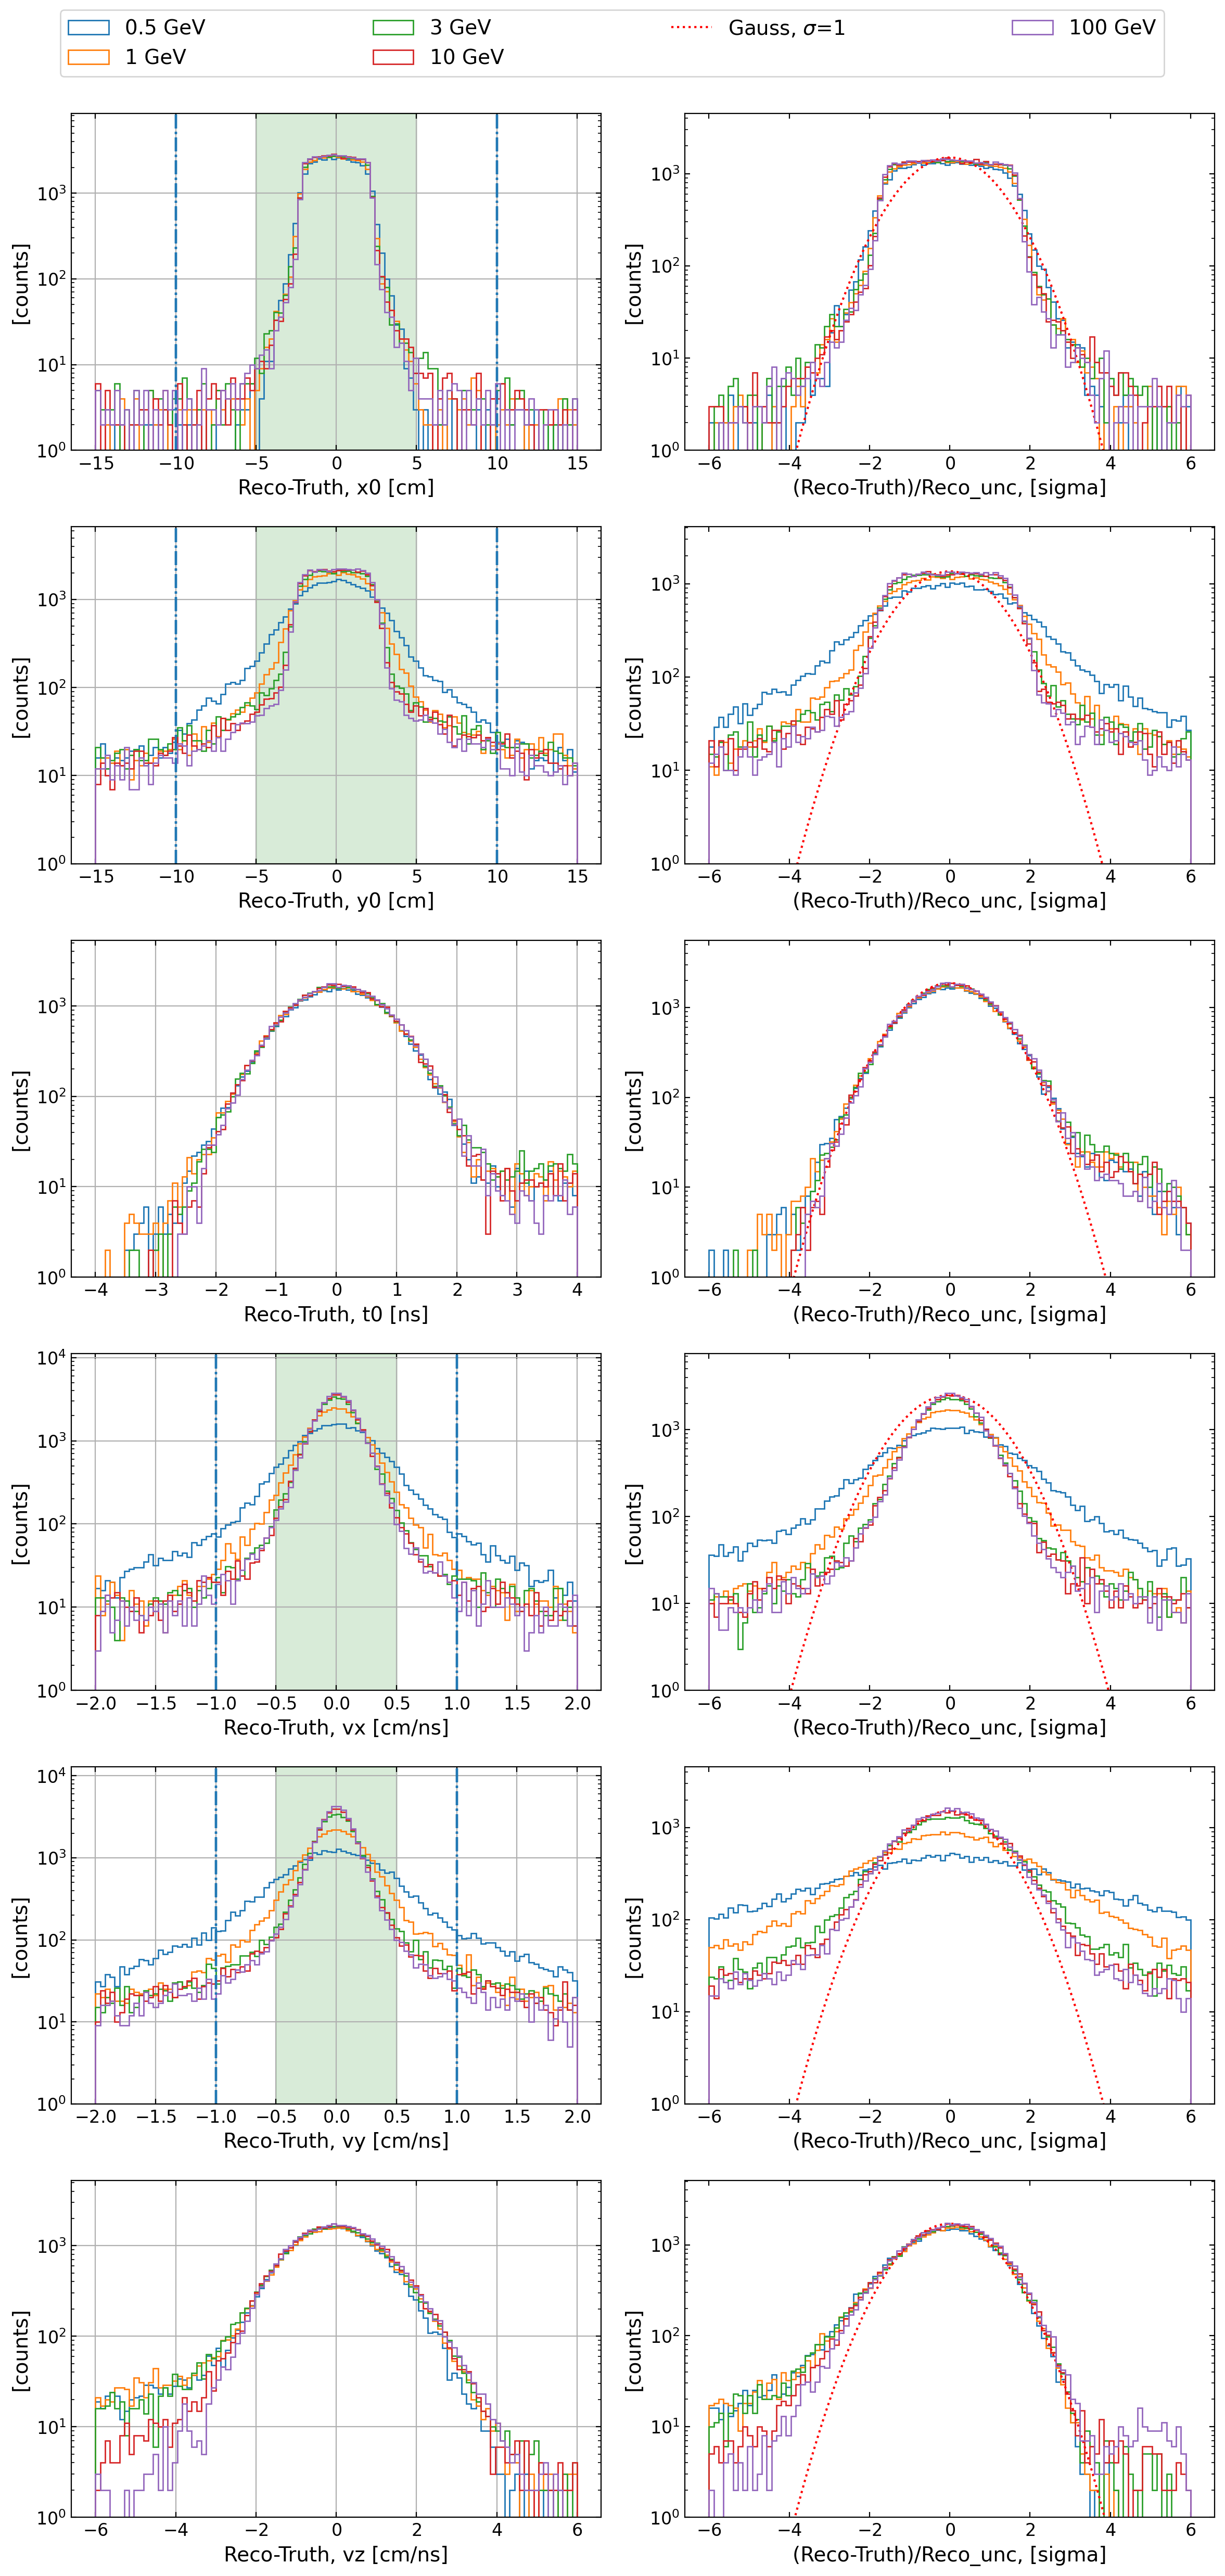

 FCN=2256.01 FROM MIGRAD    STATUS=CONVERGED      71 CALLS          72 TOTAL
                     EDM=5.22423e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.08680e+03   1.91243e+01   3.88886e-01  -4.68486e-07
   2  Mean         9.14322e-04   7.15394e-03   1.65714e-04  -3.69721e-02
   3  Sigma        1.31467e+00   3.92071e-03   1.90471e-05  -1.86742e-01
 FCN=1716.62 FROM MIGRAD    STATUS=CONVERGED      78 CALLS          79 TOTAL
                     EDM=9.31624e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.57774e+03   1.18461e+01   1.74224e-01  -1.71257e-07
   2  Mean        -5.82116e-03   1.39030e-02   2.81316e-04  -4.92633e-04
   3  Sigma        2.54754e+00   

In [7]:
track_parameters={}
efficiencies_raw={}
efficiencies_abs={}
efficiencies_abs_loose={}

efficiencies_reconstructible={}
efficiencies_4hits={}
efficiencies_cut={}
efficiencies_cut_direct={}


fig,axs=plt.subplots(6,2,figsize=(12,24))
for energy in energy_list:

    res = results[energy]
    mask_recon_success=res["mask_recon_success"]
    mask_recon_able = (res["truth_nlayer"]>5)& (res["truth_nlayer"]<=9) # layer 3 is the bottom layer, 9 is the top
    # mask_identified = (res["ndigi_track"]==(res["truth_nlayer"]-2)) # The track needs to have same number of hits as truth
    # for i in range(len(mask_identified)):
    #     if np.any(res["ndigi_inds"][i] != np.arange(0, res["ndigi_track"][i])):
    #         mask_identified[i] = False
    mask_identified= np.ones(len(res["ndigi_track"]),dtype=bool)
    for i in range(len(mask_identified)):
        for j in res["ndigi_inds"][i]:
            if j not in np.arange(0, res["ndigi_track"][i]):
                mask_identified[i] = False
                break            
    
    mask_recon_able_subset = (mask_recon_able)[mask_recon_success]
    mask_identified_subset = (mask_recon_able&mask_identified)[mask_recon_success]
    recon     =np.array(res["recon"])[mask_recon_success]
    recon_unc =np.array(res["recon_unc"])[mask_recon_success]
    truth     =np.array(res["truth"])[mask_recon_success]
    
    n_events = len(mask_recon_success)
    n_success = np.sum(mask_recon_success)
    
    axlabels=["x0 [cm]","y0 [cm]", "t0 [ns]", "vx [cm/ns]", "vy [cm/ns]", "vz [cm/ns]"]
    ranges=[[-15,15],[-15,15],[-4,4],[-2,2], [-2,2], [-6,6]]
    ind=[0,1,3,4,5,6]
    # fit_ranges=[[-0.3,0.3],
    #             [-0.3,0.3],
    #             [-3,3]]
    # fit_bins=[10,10,100]
    
    track_parameters[energy]=[]
    
    mask_3sigma = np.ones(len(recon),dtype=bool)
    
    for i in range(6):
        diff = recon[:,ind[i]]-truth[:,ind[i]]
        n,ibins,p = axs[i][0].hist(diff,bins=100,range=ranges[i],histtype="step",label=f"{energy} GeV");
        bincenters=0.5*(ibins[1:]+ibins[:-1])
        yerr=np.sqrt(n)
        yerr[yerr==0]=1
        popt,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus")
        perr = np.sqrt(np.diag(pcov))
        fw = util.Utils.fwhm(bincenters, n)
        fwhm = fw[1]-fw[0] 
        # print(popt[2], fwhm)
        
        track_parameters[energy].append([popt[2],fwhm])
        mask_temp = np.abs(diff)<fwhm*2
        mask_3sigma = mask_3sigma&mask_temp
        # print(sum(mask_3sigma)/len(mask_3sigma))
        
        axs[i][0].set_ylim(bottom=1,top=max(n)*3)
        axs[i][0].set_xlabel(f"Reco-Truth, {axlabels[i]}")
        axs[i][0].set_ylabel("[counts]")
        axs[i][0].set_yscale("log")
        axs[i][0].grid()

        recon_pull = util.pull(recon[:,ind[i]],truth[:,ind[i]], np.sqrt(recon_unc[:, ind[i]]))      
        n2,ibins2,p = axs[i][1].hist(recon_pull,bins=100,range=(-6,6),histtype="step",label=f"{energy} GeV");
        axs[i][1].set_xlabel(f"(Reco-Truth)/Reco_unc, [sigma]")
        axs[i][1].set_ylabel("[counts]")
        axs[i][1].set_yscale("log")
        # axs[i][1].grid()
        
        # Plot N(0,1) for reference in pull distribution
        if energy==10:
            bincenters=0.5*(ibins2[1:]+ibins2[:-1])
            y = util.Utils.Gauss(bincenters, max(n2),0,1)
            axs[i][1].plot(bincenters,y,color="r",label=r"Gauss, $\sigma$=1",linestyle=":")
            axs[i][1].set_ylim(bottom=1,top=max(n2)*3)
        # if i==5:
        #     axs[i][1].legend(loc=(1.1,0)) 
        
    # Make a fixed range cut for tight and looser track
    diffx = recon[:,0]-truth[:,0]
    diffy = recon[:,1]-truth[:,1]
    diffvx = recon[:,4]-truth[:,4]
    diffvy = recon[:,5]-truth[:,5]
    axs[0][0].axvspan(-5,5,alpha=0.03,color="green")
    axs[1][0].axvspan(-5,5,alpha=0.03,color="green")
    axs[3][0].axvspan(-0.5,0.5,alpha=0.03,color="green")
    axs[4][0].axvspan(-0.5,0.5,alpha=0.03,color="green")   
    axs[0][0].axvline(-10,linestyle="-.")
    axs[1][0].axvline(-10,linestyle="-.")
    axs[3][0].axvline(-1,linestyle="-.")
    axs[4][0].axvline(-1,linestyle="-.")  
    axs[0][0].axvline(10,linestyle="-.")
    axs[1][0].axvline(10,linestyle="-.")
    axs[3][0].axvline(1,linestyle="-.")
    axs[4][0].axvline(1,linestyle="-.")      
    mask_TIGHT  = (np.abs(diffx)<5) & (np.abs(diffy)<5) & (np.abs(diffvx)<0.5) & (np.abs(diffvy)<0.5)
    mask_LOOSER = (np.abs(diffx)<10) & (np.abs(diffy)<10) & (np.abs(diffvx)<1) & (np.abs(diffvy)<1)
            
            
    efficiencies_raw[energy]=list(rt.BayesDivide([sum(mask_recon_success)],[len(mask_recon_success)]))
    efficiencies_abs[energy]=list(rt.BayesDivide([sum(mask_TIGHT)],[len(mask_recon_success)]))
    efficiencies_abs_loose[energy]=list(rt.BayesDivide([sum(mask_LOOSER)],[len(mask_recon_success)]))

    efficiencies_reconstructible[energy] = list(rt.BayesDivide([sum(mask_recon_able)],[len(mask_recon_success)]))
    efficiencies_4hits[energy]=list(rt.BayesDivide([sum(mask_identified&mask_recon_able)],[sum(mask_recon_able)]))
    efficiencies_cut[energy] =list(rt.BayesDivide([sum(mask_LOOSER&mask_identified_subset)],[sum(mask_identified&mask_recon_able)]))   
    efficiencies_cut_direct[energy] =list(rt.BayesDivide([sum(mask_LOOSER&mask_recon_able_subset)],[sum(mask_recon_able)]))   
    
# legend_top_figure(ncol=4,)
handles, labels = axs[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left',ncol=4,mode="expand", bbox_to_anchor=(0.05,1.002, 0.9,0.03))
tight_layout()

savefig("all")
plt.show()

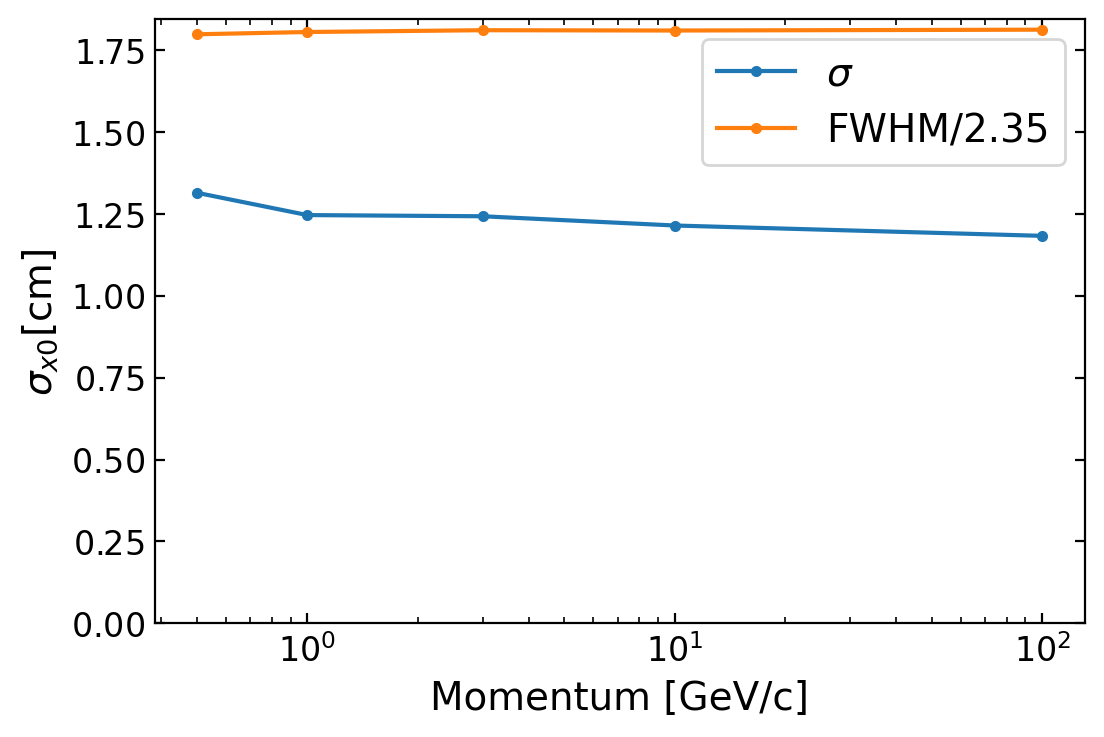

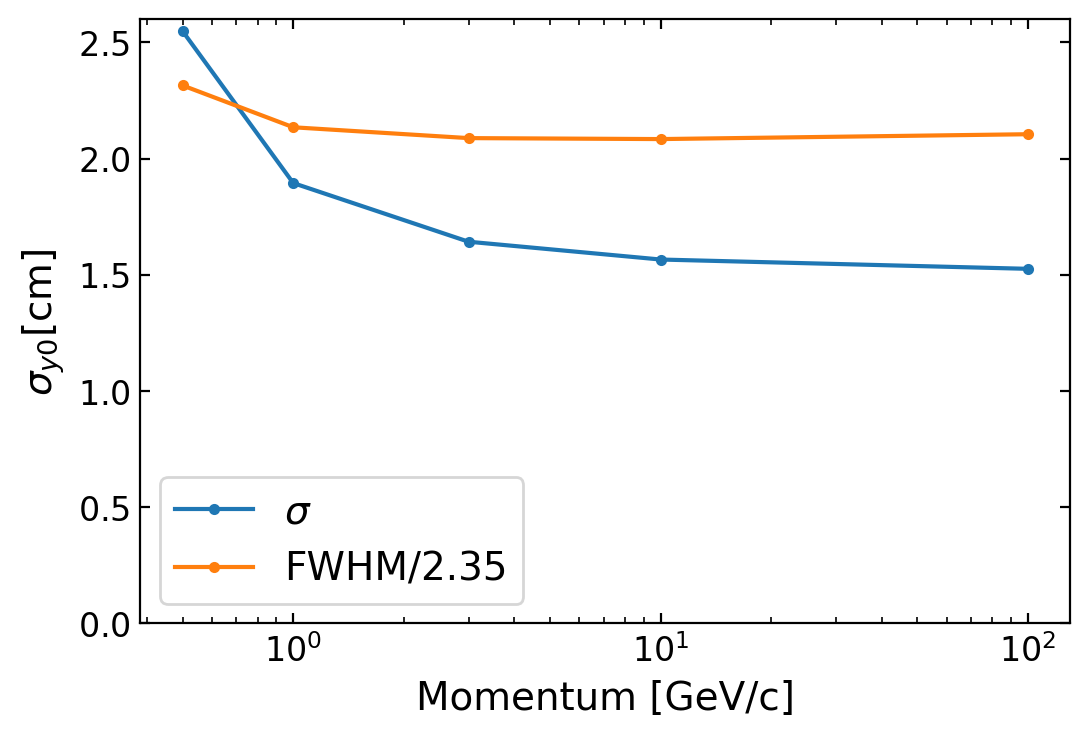

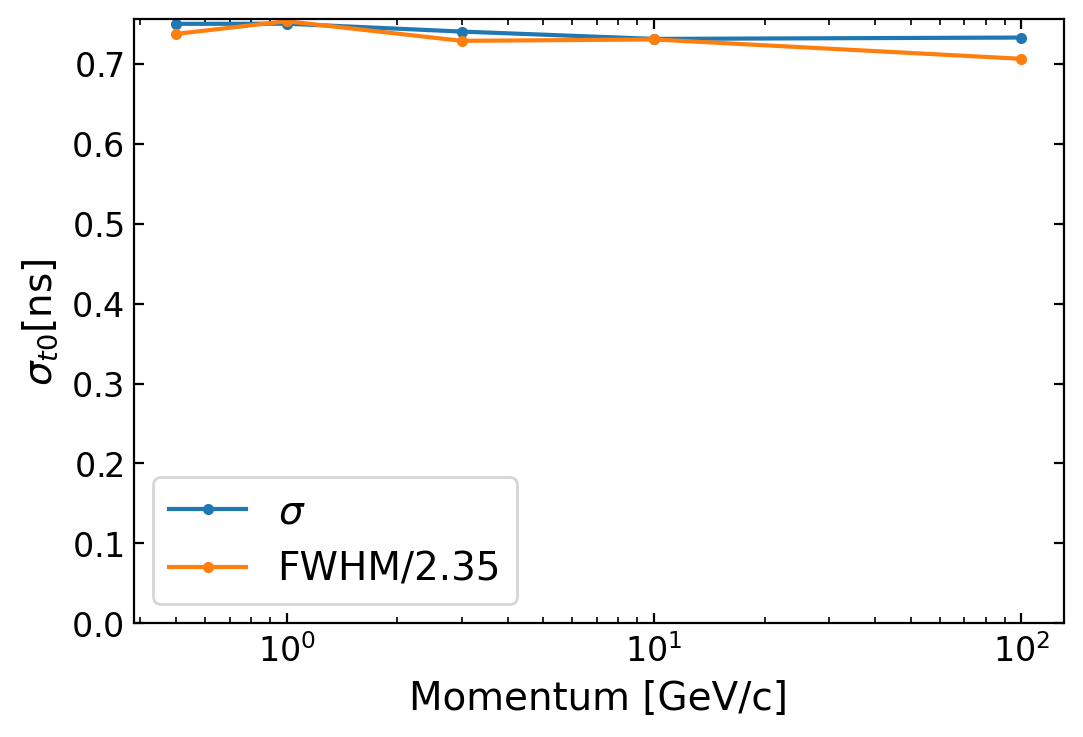

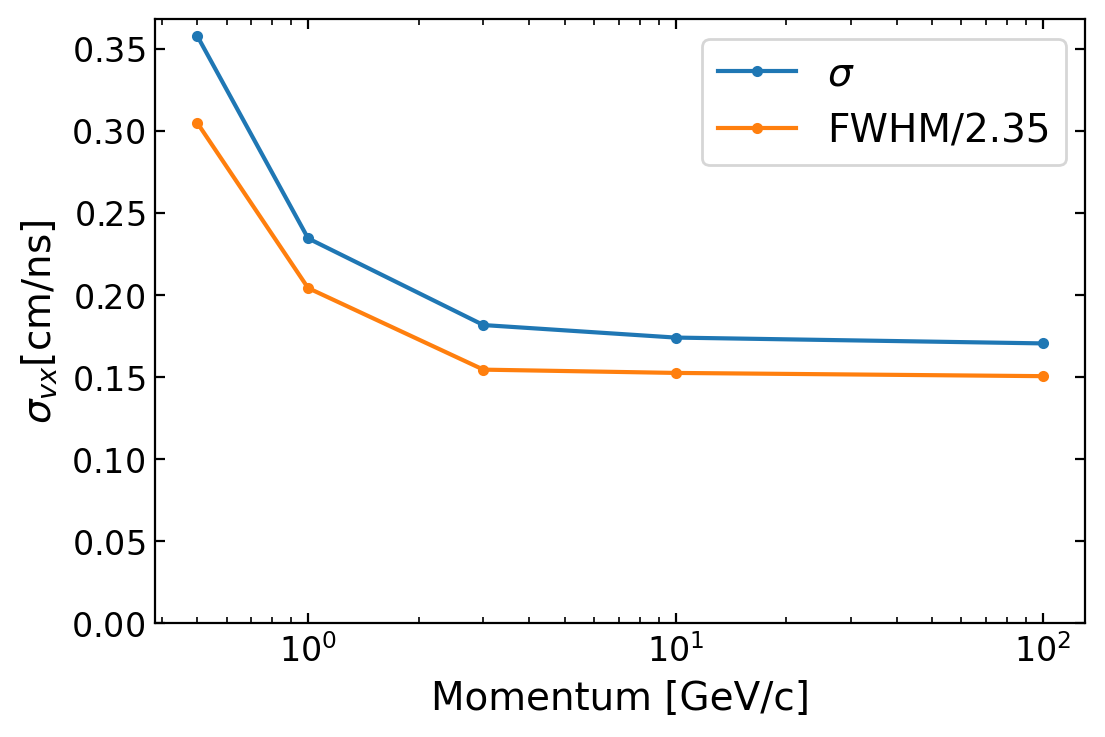

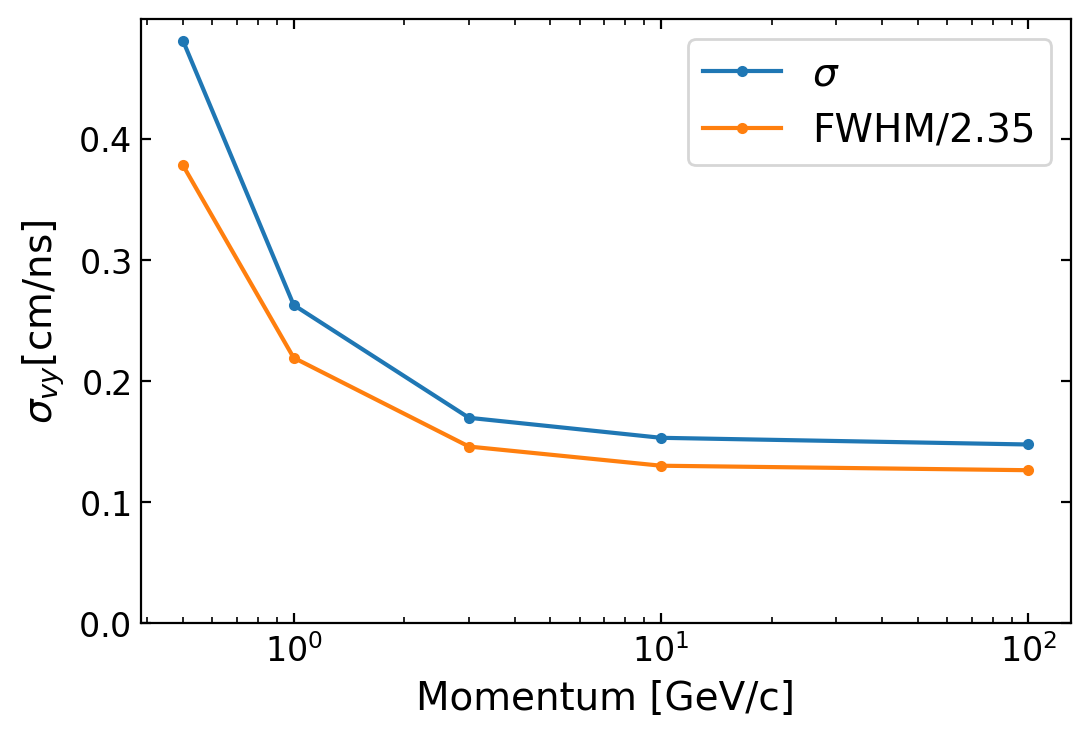

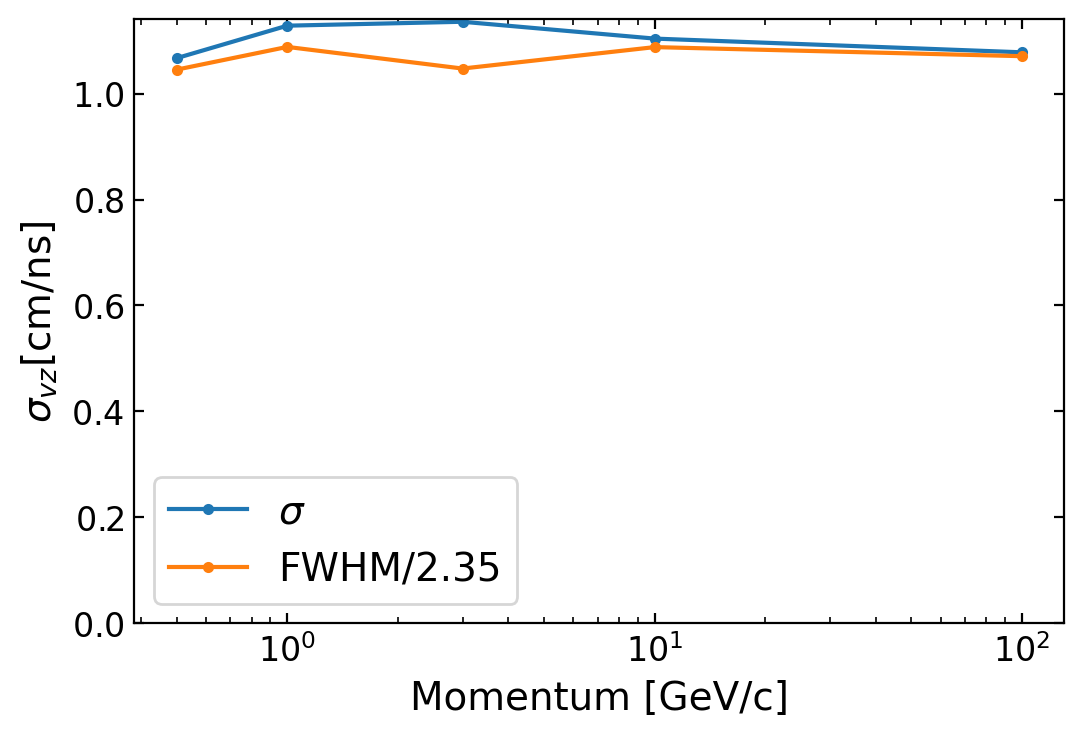

In [8]:
axlabels=["x0 [cm]","y0 [cm]", "t0 [ns]", "vx [cm/ns]", "vy [cm/ns]", "vz [cm/ns]"]
plot_data=[]
plot_data_res=[]
for ipar in range(6):
    es=[]
    sigmas = []
    fwhms=[]
    for e in track_parameters:
        res = track_parameters[e]
        es.append(e)
        sigmas.append(res[ipar][0])
        fwhms.append(res[ipar][1]/2.355)
    plot(es, sigmas,color="C0",label=r"$\sigma$",marker=".")
    plot(es, fwhms,color="C1",label="FWHM/2.35",marker=".")        
    axname = axlabels[ipar].split(" ")[0]
    t = "$\sigma_{"+ f"{axname}" + "}$" + axlabels[ipar].split(" ")[1]
    ylabel(fr"{t}")
    xlabel("Momentum [GeV/c]")
    legend()
    xscale('log')
    ylim(bottom=0)
    show()
    
    plot_data_res.append([es,sigmas,fwhms])
    

['/project/def-mdiamond/tomren/mathusla/data/fit_study/plot_data_pion_singletrack.jojblib']

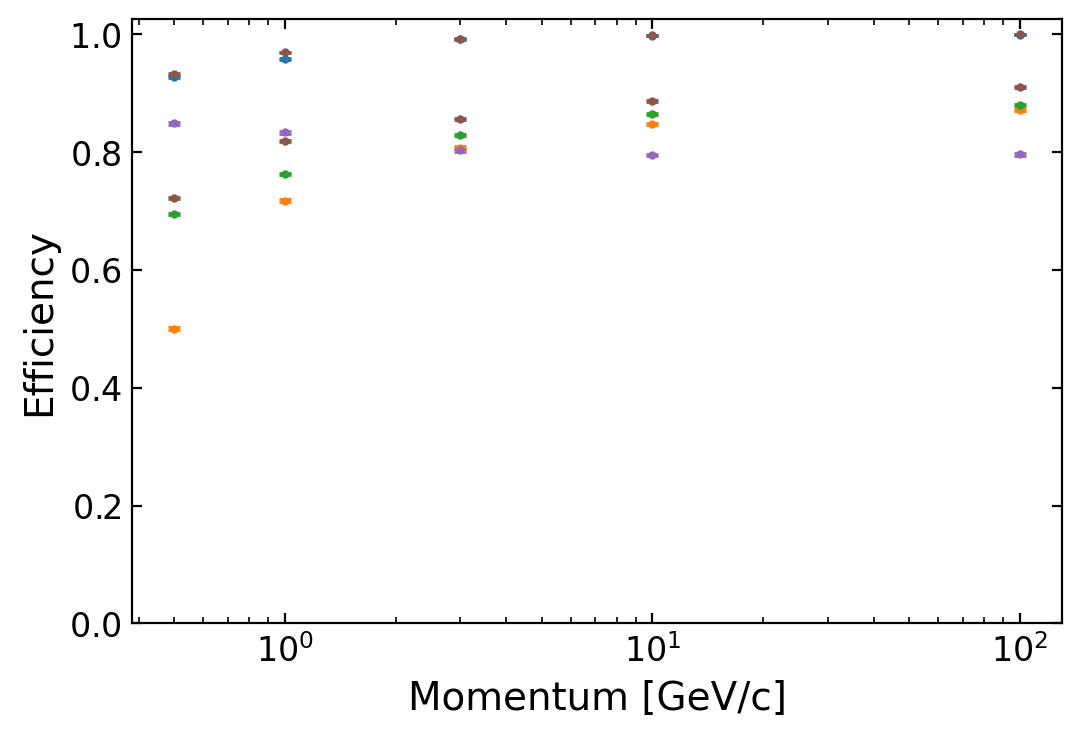

In [9]:
es=[]
effs1=[]
effs1_err_l=[]
effs1_err_h=[]
effs2=[]
effs2_err_l=[]
effs2_err_h=[]
effs3=[]
effs3_err_l=[]
effs3_err_h=[]
effs4=[]
effs4_err_l=[]
effs4_err_h=[]
effs5=[]
effs5_err_l=[]
effs5_err_h=[]
effs6=[]
effs6_err_l=[]
effs6_err_h=[]

for e in efficiencies_raw:
    es.append(e)
    
    eff = efficiencies_raw[e]
    effs1.append(eff[0][0])
    effs1_err_l.append(eff[1][0])
    effs1_err_h.append(eff[2][0])
    errorbar(e, eff[0][0], yerr=[eff[1],eff[2]],fmt="o-",color="C0",markersize=2,capsize=2)
    
    eff = efficiencies_abs[e]
    effs2.append(eff[0][0])
    effs2_err_l.append(eff[1][0])
    effs2_err_h.append(eff[2][0])    
    errorbar(e, eff[0][0], yerr=[eff[1],eff[2]],fmt="o-",color="C1",markersize=2,capsize=2)
    
    eff = efficiencies_reconstructible[e]
    effs3.append(eff[0][0])
    effs3_err_l.append(eff[1][0])
    effs3_err_h.append(eff[2][0])    
    errorbar(e, eff[0][0], yerr=[eff[1],eff[2]],fmt="o-",color="C2",markersize=2,capsize=2,label="e_recon-able") 
    
    eff = efficiencies_4hits[e]
    effs4.append(eff[0][0])
    effs4_err_l.append(eff[1][0])
    effs4_err_h.append(eff[2][0])    
    errorbar(e, eff[0][0], yerr=[eff[1],eff[2]],fmt="o-",color="C4",markersize=2,capsize=2,label="e_recog")   
    
    eff = efficiencies_cut[e]
    effs5.append(eff[0][0])
    effs5_err_l.append(eff[1][0])
    effs5_err_h.append(eff[2][0])    
    errorbar(e, eff[0][0], yerr=[eff[1],eff[2]],fmt="o-",color="C5",markersize=2,capsize=2,label="e_param")     
    
    
    eff = efficiencies_abs_loose[e]
    effs6.append(eff[0][0])
    effs6_err_l.append(eff[1][0])
    effs6_err_h.append(eff[2][0])    
    errorbar(e, eff[0][0], yerr=[eff[1],eff[2]],fmt="o-",color="C5",markersize=2,capsize=2,label="e_param")         
    
plot_data_eff = [es, 
                 [effs1,effs1_err_l,effs1_err_h],  
                 [effs2,effs2_err_l,effs2_err_h],  
                 [effs3,effs3_err_l,effs3_err_h],
                 [effs4,effs4_err_l,effs4_err_h],
                 [effs5,effs5_err_l,effs5_err_h],
                 [effs6,effs6_err_l,effs6_err_h]]

plot_data = [plot_data_res,plot_data_eff]
    
xlabel("Momentum [GeV/c]")
ylabel("Efficiency")
xscale("log")
ylim(bottom=0)
# legend()

joblib.dump(plot_data,f"{DATA_DIR}/plot_data_pion_singletrack.jojblib")